In [11]:
from mpl_toolkits import mplot3d

In [12]:
import matplotlib.colors as mcolors

In [13]:
from pylab import rcParams

In [14]:
from numpy import inf
from numpy import nan

In [15]:
from numpy.linalg import norm

In [16]:
import multiprocessing as mp

In [17]:
%matplotlib inline 

In [18]:
import numpy as np

In [19]:
from scipy.optimize import differential_evolution

In [20]:
import math

In [21]:
from scipy.stats import entropy

In [22]:
import matplotlib.pyplot as plt

In [23]:
from matplotlib.font_manager import FontProperties

In [24]:
from matplotlib.ticker import FormatStrFormatter


In [25]:
# import seaborn as sns; sns.set()

In [26]:
import time

In [27]:
# popSize =2000
popSize =500

In [28]:
# mu = 0.01
mu = 0.1

In [29]:
sigma=0.005

In [30]:
n = 10
contribution = 1

In [31]:
age_group = 0 # 0 for young and 1 for old

In [32]:
r = 0.5
# beta =0.5 # difficulty of foraging for young group
gamma = 0 # extra benefit of foraging for old

# Benefits

In [33]:
def benefit_f(G,b,beta):

    G = np.array(G)
    X = 1-G[:,0]
    L = G[:,1]
    B_F = b* np.dot(L,X) 
    #     B_F = 2
    return (B_F)

In [34]:
def benefit_t(G,b,beta):
    G = np.array(G)
    X = G[:,0]
    L = G[:,1]
    temp = np.dot(X,L)
    
    #concave function    A #
    B_T = (-4/(n**2))*(temp**2) + 4/n *(temp)


    return (B_T)

## Total Benefit

In [35]:
def benefit(G,b,beta):
    return(1/n * benefit_f(G,b,beta)*contribution * benefit_t(G,b,beta) + (1-contribution)*benefit_f(G,b,beta))
#     return(1/n* benefit_t(G,b,r))

# Costs

In [36]:
def cost_t(player,b,beta):
#     return(r*(player[0])*player[1]*np.exp(beta*(age_group)))
    return(r*(player[0])*player[1])

In [37]:
def cost_f(player,b,beta):
    

    #concave function   D #
    return((-((1-player[0])**2)*(player[1]**2) + (2)*(((player[1])) * ((1-player[0]))))*np.exp(beta*(1-player[2])))


## Total cost

In [38]:
def cost(player,b,beta):
    return (cost_t(player,b,beta) + cost_f(player,b,beta))

## Payoff

In [39]:
def payoffGame(G,b,beta):
    B = np.repeat(benefit(G,b,beta),len(G))
    C = list(map(cost,G,[b]*len(G),[beta]*len(G)))
    return (B-C)

## Mutations

In [40]:
def mutateIf_x(traitValue):
    if np.random.uniform(0,1) < mu :
        return np.clip(np.random.normal(traitValue,sigma),0, 1)
    else:
        return traitValue

In [41]:
def mutateIf_l(traitValue):
    return 1


# monomorphic population

### local movement

In [44]:
def oneRound(b,beta,alpha):
    global population
    global X
    global L
    global Age
    global piii
    global allp
    np.random.shuffle(population)
    allGames = np.split(population,popSize/n)
#     allGames = np.split(population,(np.shape(population)[0])/n)
    allPayoff = np.array(list(map(payoffGame, allGames,[b]*len(allGames),[beta]*len(allGames))))
    allPayoffs = allPayoff.flatten()
    allA=np.copy(population[:,2])
    allX=np.copy(population[:,0])
    piii = sum(allPayoffs)/np.shape(population)[0]
    allPayoffs = np.exp(np.multiply(allPayoffs,1))
#     allPayoffs[allPayoffs<=0] = 0.0001
    allp =np.copy(allPayoffs)
    
    
    young_age_similarity = np.exp(np.multiply(abs(allA-0), -alpha*10))
    old_age_similarity = np.exp(np.multiply(abs(allA-1), -alpha*10))
#     young_age_similarity = 1-abs(allA-0)*alpha
#     old_age_similarity = 1-abs(allA-1)*alpha
    young_parents_x = np.random.choice(population[:,0],int(popSize/2),p=(np.multiply(allPayoffs,young_age_similarity))/np.sum((np.multiply(allPayoffs,young_age_similarity))))
    old_parents_x = np.random.choice(population[:,0],int(popSize/2),p=(np.multiply(allPayoffs,old_age_similarity))/np.sum((np.multiply(allPayoffs,old_age_similarity))))
    young_parents = [[x,1,0] for x in young_parents_x]
    old_parents = [[x,1,1] for x in old_parents_x]
    parents = young_parents + old_parents
    
    
    parents=np.array(parents)  

   
    X = np.array(list(map(mutateIf_x,population[:,0])))
    L = np.array(list(map(mutateIf_l,population[:,1])))
    Age=population[:,2]
    
    population=np.ndarray.tolist(population)
    X=np.ndarray.tolist(X)
    L=np.ndarray.tolist(L)
    Age=np.ndarray.tolist(Age)
    for i in range(len(population)):
        population[i][0]=X[i]
        population[i][1]=L[i]
        population[i][2]=Age[i]
    population=np.array(population)
    X=np.array(X)
    L=np.array(L)
    Age=np.array(Age)


In [45]:
class Flexlist(list):
    def __getitem__(self, keys):
        if isinstance(keys, (int, slice)): return list.__getitem__(self, keys)
        return [self[k] for k in keys]

## Play

In [46]:
def play(startTrait, tEnd, plotInterval,b,beta,alpha):
    global popSize
    global population
    global X
    global L
    global Age
    global piii
    global allp

#     population = np.array(startTrait*popSize)
    pop1=[[startTrait[0],startTrait[1],age_group]]* int(popSize/2)
    pop2=[[startTrait[0],startTrait[1],1-age_group]]* (popSize-int(popSize/2))
    population = np.concatenate((pop1,pop2))
#     population = np.array(pop1)
    
    global allPopulations
    global allLaziness
    global allAges
    global len_pop
    allPopulations=[]
    allLaziness=[]
    allAges=[]
    len_pop =[]
    for t in range(1,tEnd+1):
        if (t%plotInterval == 0):
            allPopulations.append(X)
            allLaziness.append(L)
            allAges.append(Age)
            len_pop.append(len(X))
        oneRound(b,beta,alpha)
# 

In [58]:
 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.font_manager import FontProperties
import numpy as np

def plotEvolutions(tEnd, plotInterval, b, beta, alpha):
    global popSize
    global allPopulations
    global allLaziness
    global allAges
    global len_pop

    # Create x, y, z, w for plotting
    x = np.hstack([np.full(len_pop[i-1], i * plotInterval) for i in range(1, 1 + tEnd // plotInterval)])
    y = np.hstack(allPopulations)
    w = np.hstack(allAges)

    # Set font and figure properties
    plt.rcParams["font.family"] = "serif"
    font_properties = FontProperties(weight='bold', size=13)

    # First Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x[w == 1], y[w == 1], ".", color="darkmagenta", markersize=0.08, label='O')
    # ax.legend(loc='upper left', markerscale=30, shadow=True, prop={'size': 12, 'weight': 'bold'})
    # ax.set_xlabel('Time Step', fontsize=14, fontweight="bold")
    # ax.set_ylabel('Trait Value (x)', fontsize=14, fontweight="bold")
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    # Set x-ticks at every 5000 steps
    xticks = np.arange(0, tEnd + 1, 5000)
    ax.set_xticks(xticks)
    ax.set_ylim(0, 1)
    ax.margins(0)
    ax.set_aspect(aspect='auto')
    plt.grid(visible=True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('./data/b20r0.25_1.pdf',bbox_inches='tight')
    plt.show();

    # Second Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x[w == 0], y[w == 0], ".", color="olivedrab", markersize=0.01, label='Y')
    # ax.legend(loc='upper left', markerscale=30, shadow=True, prop={'size': 12, 'weight': 'bold'})
    # ax.set_xlabel('Time Step', fontsize=14, fontweight="bold")
    # ax.set_ylabel('Trait Valuex (x)', fontsize=14, fontweight="bold")
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    # Set x-ticks at every 5000 steps
    xticks = np.arange(0, tEnd + 1, 5000)
    ax.set_xticks(xticks)
    ax.set_ylim(0, 1)
    ax.margins(0)
    ax.set_aspect(aspect='auto')
    plt.grid(visible=True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('./data/b20r0.25_2.pdf',bbox_inches='tight')
    plt.show();
    
    
    
   
   


In [59]:
def run(startTrait, tEnd, plotInterval,b,beta,alpha):
    start = time.time() # should use process_time but only available in Python 3.3 and up 
    play(startTrait, tEnd, plotInterval,b,beta,alpha)
    end = time.time() 
    print(end - start)
    plotEvolutions(tEnd, plotInterval,b,beta,alpha)
    print(piii)

### initial traits

In [60]:
x = 0.5
l = 1



# Different b values for $\alpha =0$ 

##  $b=2, \beta=0.5, \alpha =0$ 

9.042285919189453


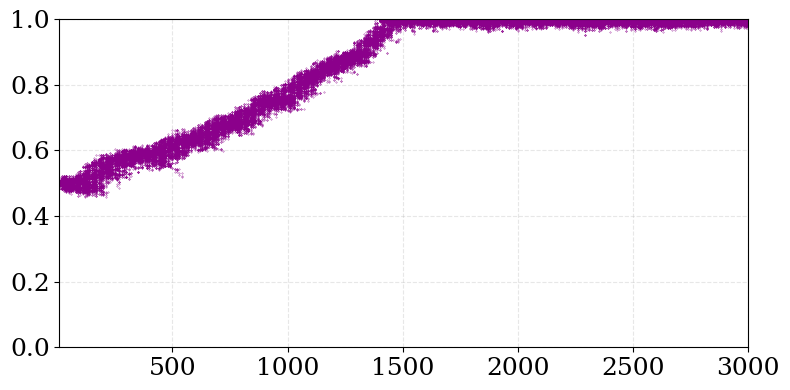

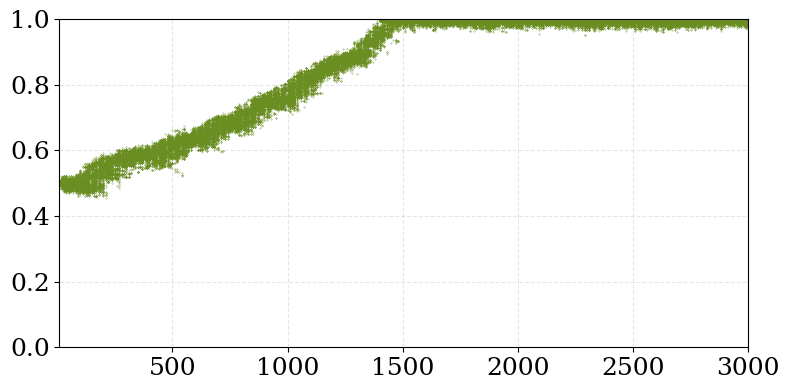

-0.5114057032164767


In [66]:
run([x,l],3000,10,2,0.5,0)

##  $b=20, \beta=0, \alpha =0$ 

60.94446921348572


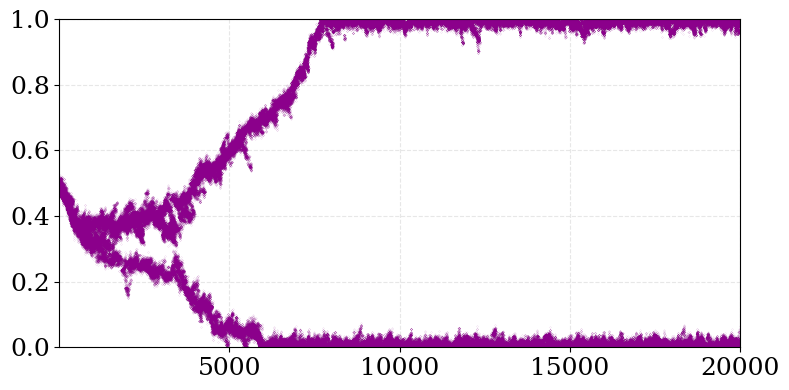

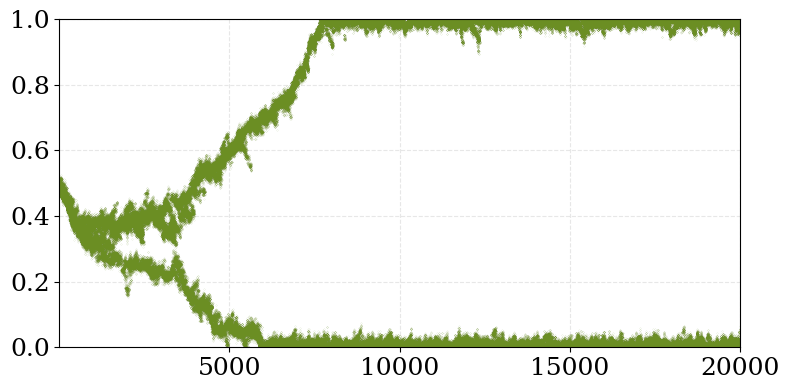

8.347760501070113


In [111]:
run([x,l],20000,10,20,0,0)

##  $b=20, \beta=0.25, \alpha =0$ 

65.92849802970886


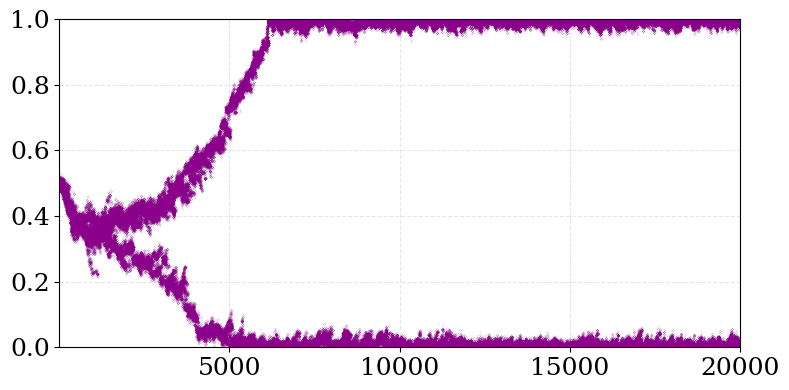

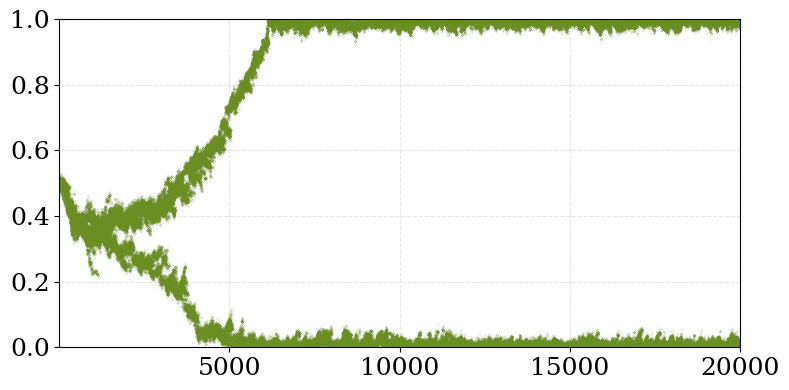

7.370495607293607


In [115]:
run([x,l],20000,10,20,0.25,0)

##  $b=20, \beta=0.75, \alpha =0$ 

75.78102493286133


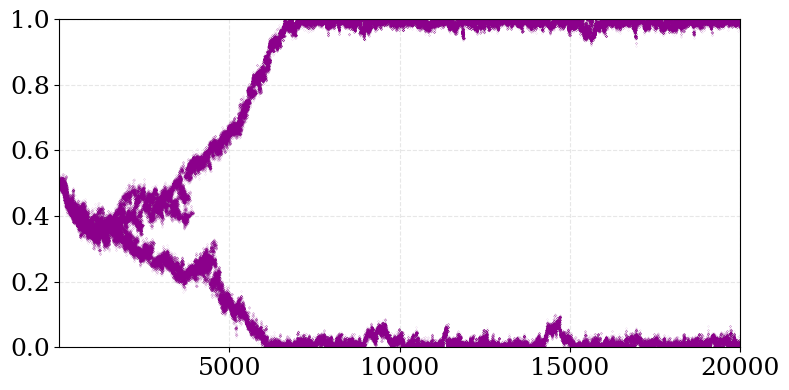

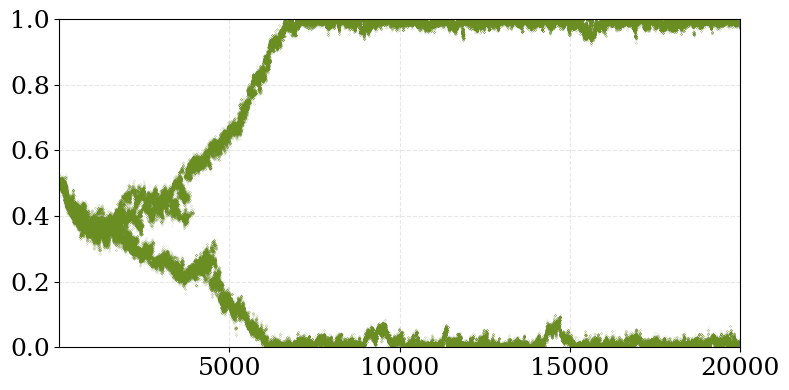

6.172705326663676


In [119]:
run([x,l],20000,10,20,0.75,0)

# Different b values for $\alpha =1$ 

##  $b=20, \beta=0, \alpha =1$ 

243.1030237674713


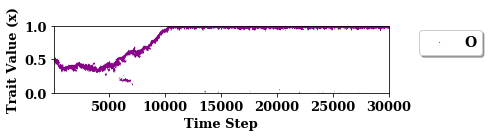

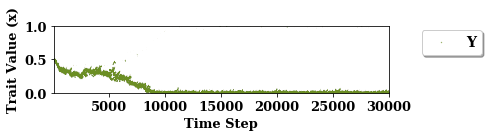

8.65569549406351


In [125]:
run([x,l],20000,10,20,0,1)

68.1665027141571


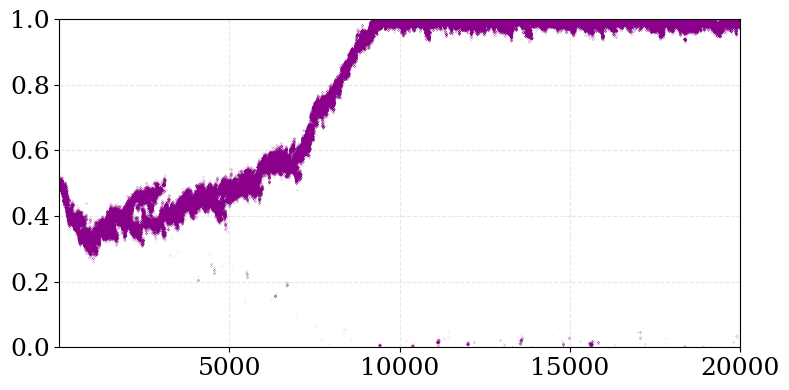

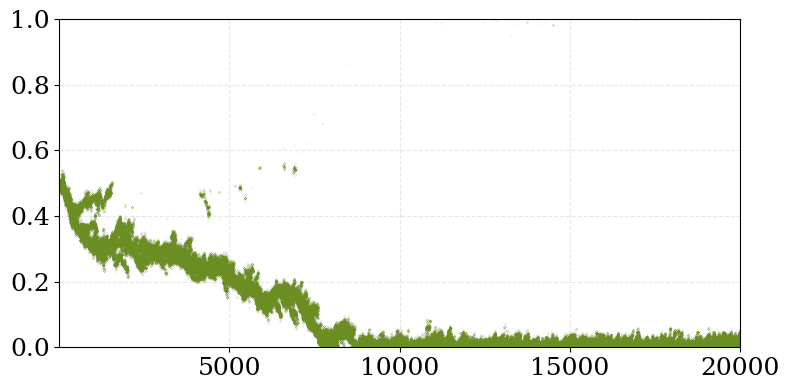

8.496578897607714


In [125]:
run([x,l],20000,10,20,0,1)

318.8998689651489


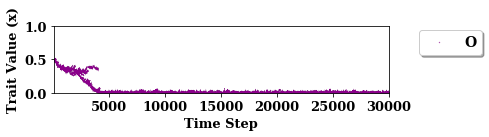

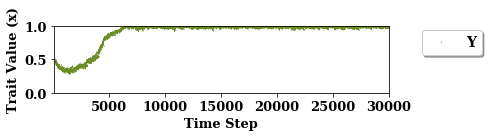

8.585302711820226


In [59]:
run([x,l],20000,10,20,0,1)

##  $b=20, \beta=0.25, \alpha =1$ 

58.8253538608551


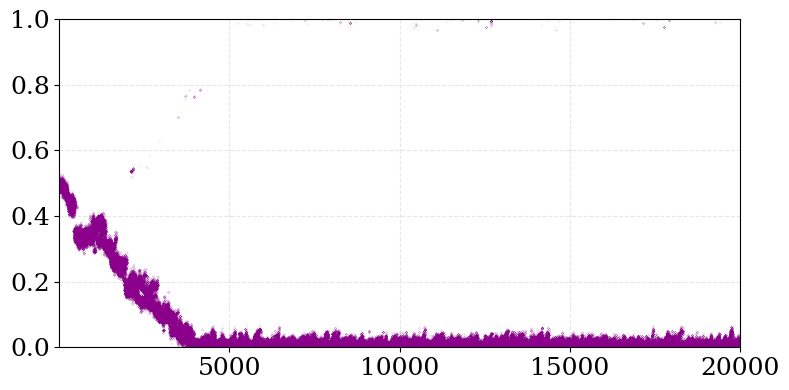

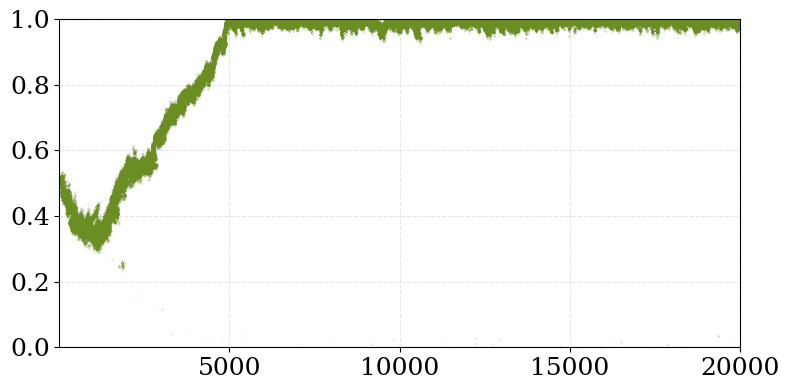

8.684459956023804


In [129]:
run([x,l],20000,10,20,0.25,1)

##  $b=20, \beta=0.75, \alpha =1$ 

72.49009656906128


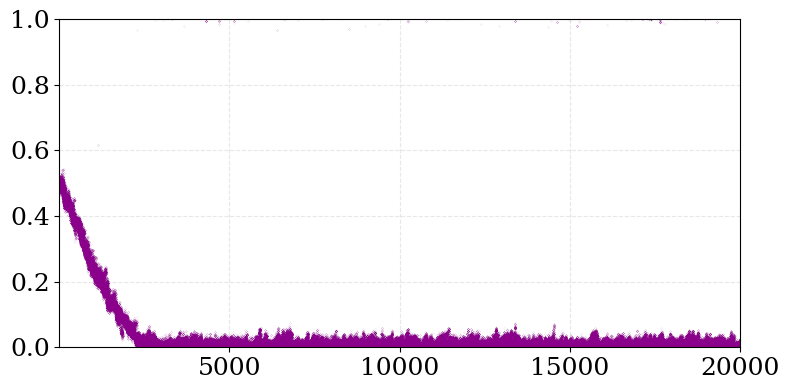

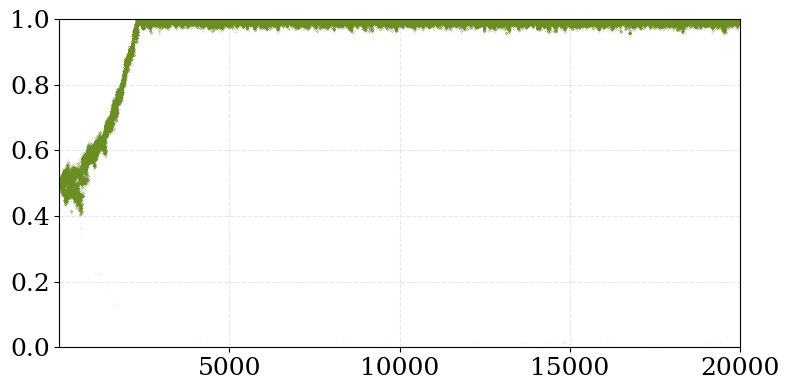

8.546641954870195


In [133]:
run([x,l],20000,10,20,0.75,1)

# Different b values for $\alpha =0.5$ 

##  $b=2, \beta=0.5, \alpha =0.5$ 

59.69320344924927


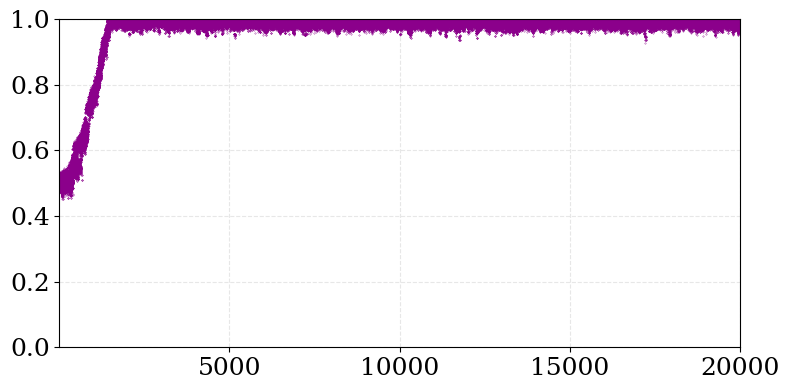

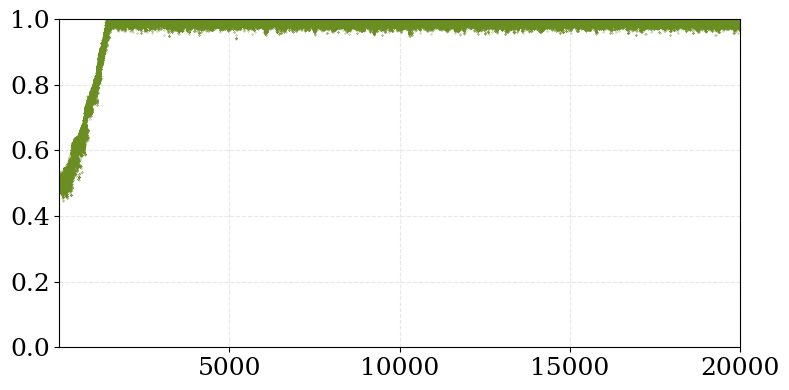

-0.5145457651766369


In [76]:
run([x,l],20000,10,2,0.5,0.5)

254.07902908325195


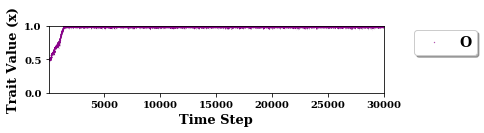

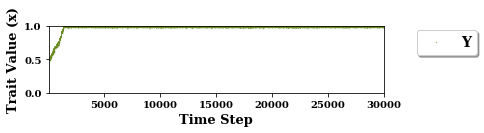

-0.5150657037420089


In [581]:
run([x,l],30000,10,2,0.5,0.5)

In [582]:
young_pop_b2_beta05 = allPopulations[-1][allAges[-1]==0]
old_pop_b2_beta05 = allPopulations[-1][allAges[-1]==1]

##  $b=20, \beta=0, \alpha =0.5$ 

60.392498254776


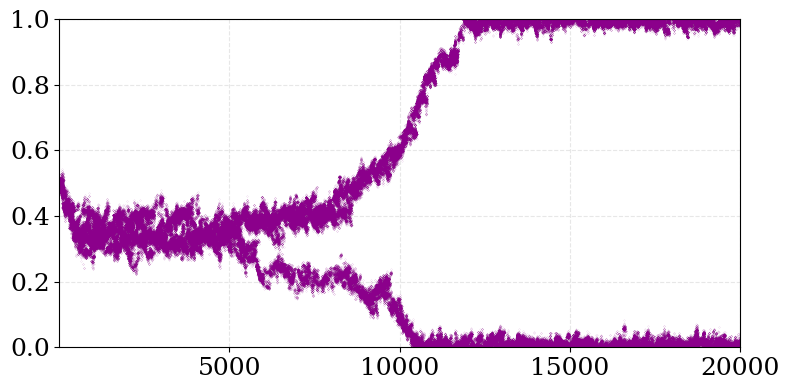

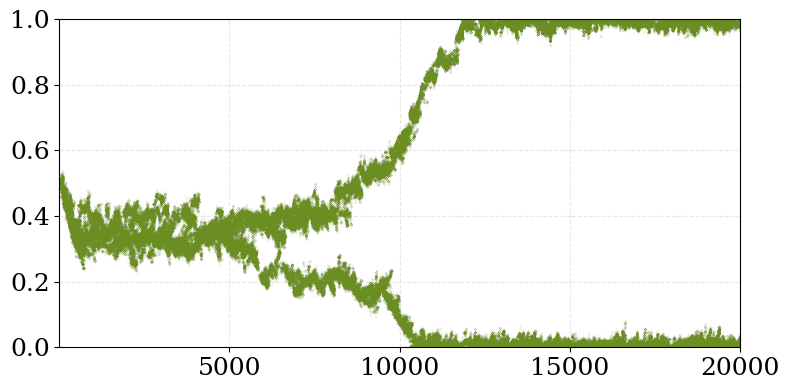

8.445558360389967


In [107]:
run([x,l],20000,10,20,0,0.5)

261.9699378013611


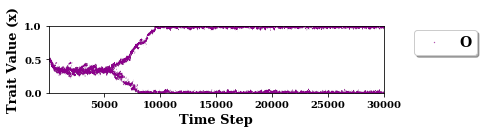

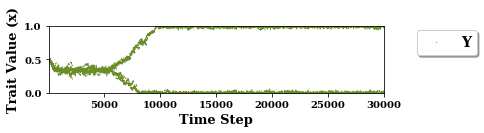

7.589616653413251


In [615]:
run([x,l],30000,10,20,0,0.5)

In [616]:
young_pop_b20_beta0 = allPopulations[-1][allAges[-1]==0]
old_pop_b20_beta0 = allPopulations[-1][allAges[-1]==1]

In [617]:
print(len(young_pop_b20_beta0[young_pop_b20_beta0>0.5]))
print(len(old_pop_b20_beta0[old_pop_b20_beta0>0.5]))

44
224


##  $b=20, \beta=0.25, \alpha =0.5$ 

61.88362908363342


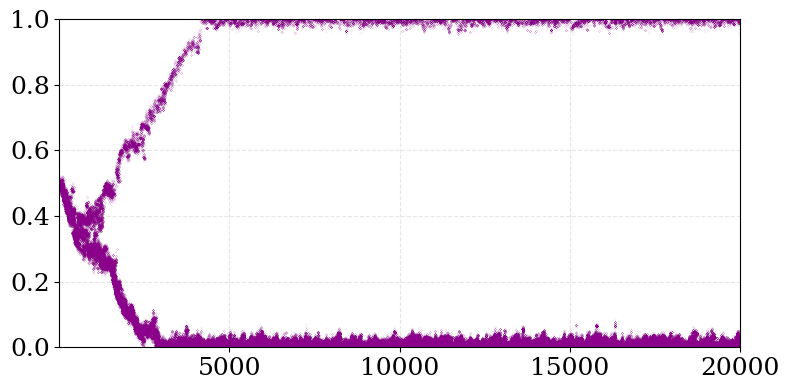

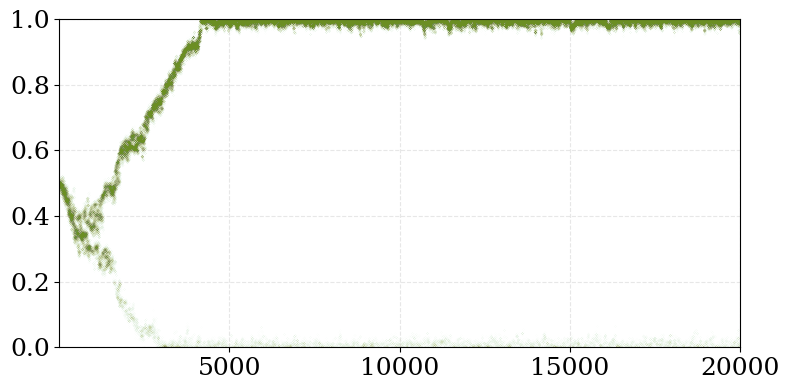

8.150165872700516


In [61]:
run([x,l],20000,10,20,0.25,0.5)

256.15848183631897


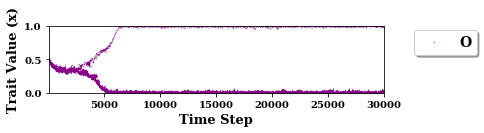

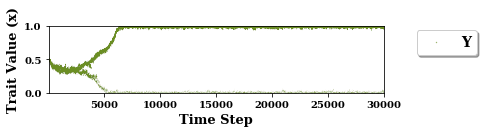

8.67329400714213


In [586]:
run([x,l],30000,10,20,0.25,0.5)

In [587]:
young_pop_b20_beta025 = allPopulations[-1][allAges[-1]==0]
old_pop_b20_beta025 = allPopulations[-1][allAges[-1]==1]

In [588]:
print(len(young_pop_b20_beta025[young_pop_b20_beta025>0.5]))
print(len(old_pop_b20_beta025[old_pop_b20_beta025>0.5]))

246
4


##  $b=20, \beta=0.5, \alpha =0.5$ 

254.28678393363953


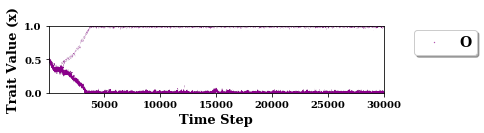

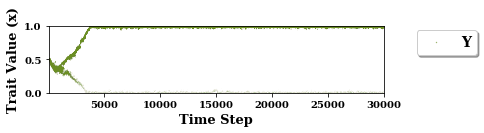

8.428904414856797


In [589]:
run([x,l],30000,10,20,0.5,0.5)

In [590]:
young_pop_b20_beta05 = allPopulations[-1][allAges[-1]==0]
old_pop_b20_beta05 = allPopulations[-1][allAges[-1]==1]

In [591]:
print(len(young_pop_b20_beta05[young_pop_b20_beta05>0.5]))
print(len(old_pop_b20_beta05[old_pop_b20_beta05>0.5]))

245
3


##  $b=20, \beta=0.75, \alpha =0.5$ 

61.530712842941284


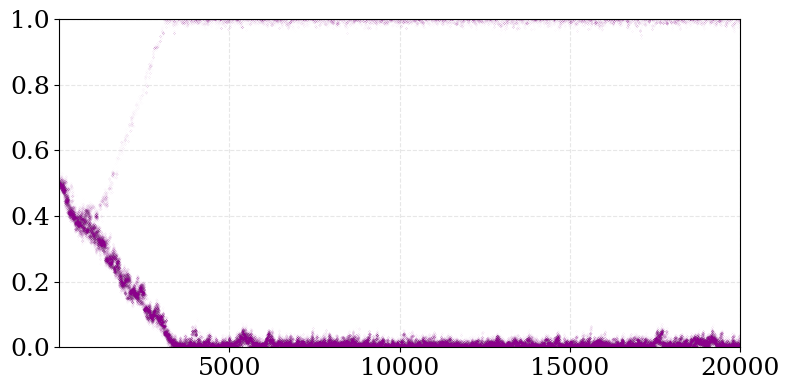

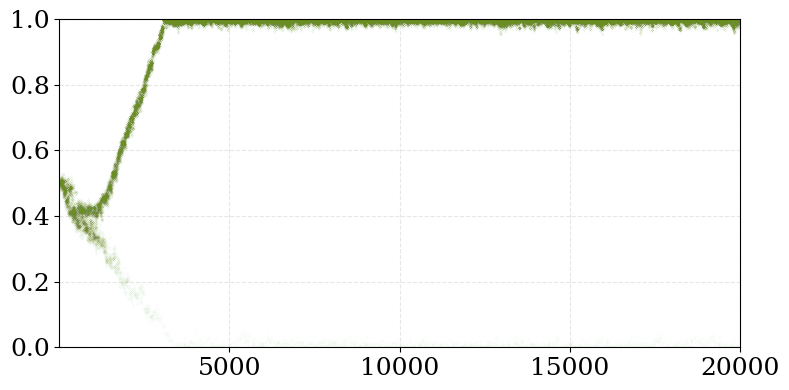

7.716554528720334


In [50]:
run([x,l],20000,10,20,0.75,0.5)

257.85250091552734


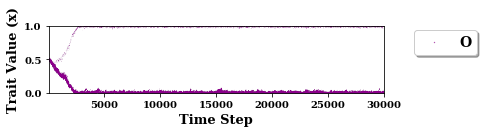

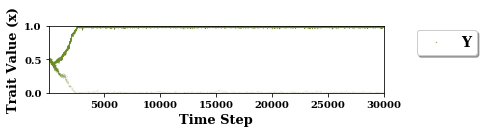

8.14007346021256


In [592]:
run([x,l],30000,10,20,0.75,0.5)

In [593]:
young_pop_b20_beta075 = allPopulations[-1][allAges[-1]==0]
old_pop_b20_beta075 = allPopulations[-1][allAges[-1]==1]

In [594]:
print(len(young_pop_b20_beta075[young_pop_b20_beta075>0.5]))
print(len(old_pop_b20_beta075[old_pop_b20_beta075>0.5]))

247
9


##  $b=20, \beta=1, \alpha =0.5$ 

266.5043511390686


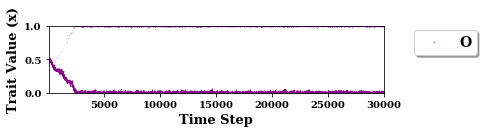

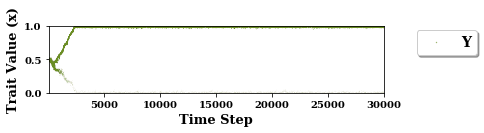

7.89065520574823


In [610]:
run([x,l],30000,10,20,1,0.5)

In [596]:
young_pop_b20_beta1 = allPopulations[-1][allAges[-1]==0]
old_pop_b20_beta1 = allPopulations[-1][allAges[-1]==1]

In [597]:
print(len(young_pop_b20_beta1[young_pop_b20_beta1>0.5]))
print(len(old_pop_b20_beta1[old_pop_b20_beta1>0.5]))

244
7


In [605]:
young_pop_b20_beta2 = allPopulations[-2][allAges[-2]==0]
old_pop_b20_beta2 = allPopulations[-2][allAges[-2]==1]

In [606]:
print(len(young_pop_b20_beta2[young_pop_b20_beta2>0.5]))
print(len(old_pop_b20_beta2[old_pop_b20_beta2>0.5]))

0
0


##  $b=42, \beta=0.1, \alpha =0.5$ 

274.8503279685974


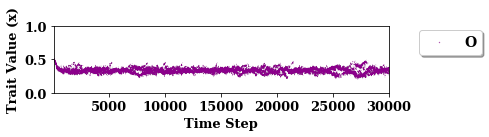

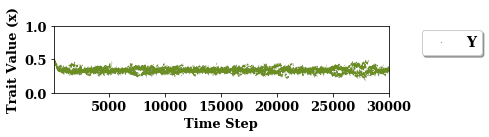

23.767641397327864


In [693]:
run([x,l],30000,10,42,0.1,0.5)

259.87607502937317


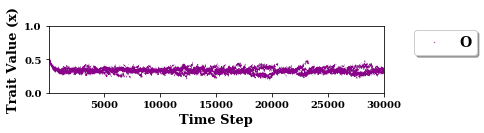

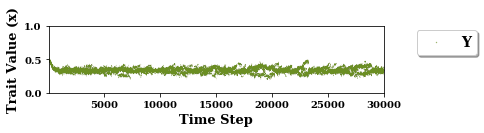

23.771419654439757


In [601]:
run([x,l],30000,10,42,0.1,0.5)

In [602]:
young_pop_b42_beta01 = allPopulations[-1][allAges[-1]==0]
old_pop_b42_beta01 = allPopulations[-1][allAges[-1]==1]

279.6524670124054


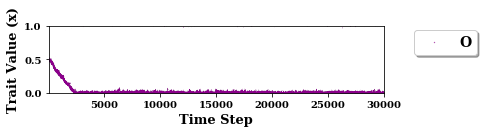

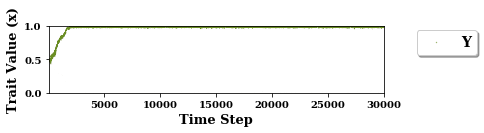

7.998285827440058


In [608]:
run([x,l],30000,10,20,1,1)

# Different b values for $\alpha =0.2$ 

264.74081206321716


/Users/mkha0093/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


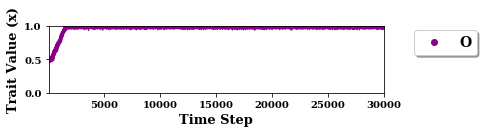

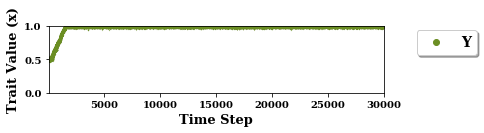

-0.511535843181811


In [446]:
run([x,l],30000,10,2,0.5,0.2)

270.00403594970703


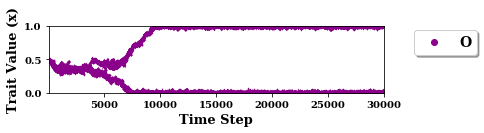

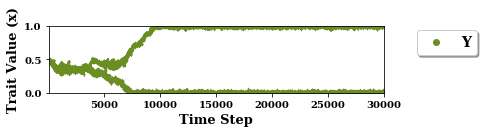

7.408404239501384


In [447]:
run([x,l],30000,10,18,0,0.2)

248.35947179794312


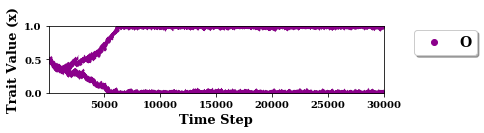

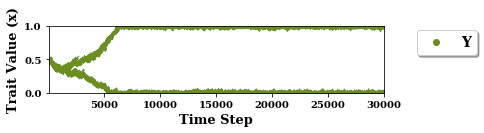

6.499117616727245


In [448]:
run([x,l],30000,10,18,0.25,0.2)

253.1574821472168


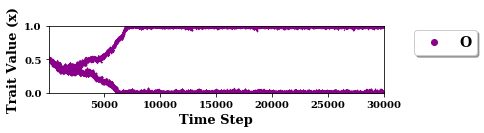

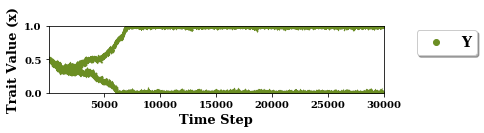

6.252436714782506


In [449]:
run([x,l],30000,10,18,0.5,0.2)

262.6631050109863


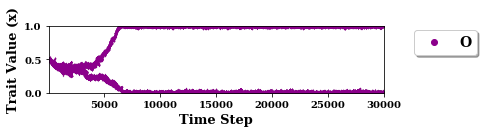

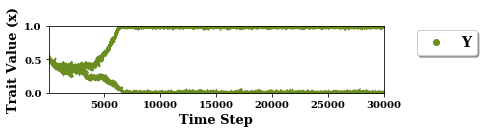

6.097621235226298


In [450]:
run([x,l],30000,10,18,0.75,0.2)

248.14556503295898


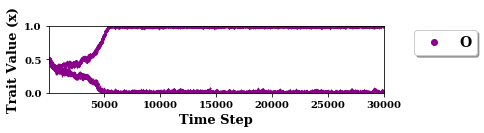

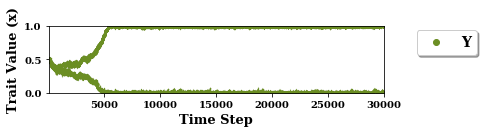

5.108623352817017


In [451]:
run([x,l],30000,10,18,1,0.2)

249.961021900177


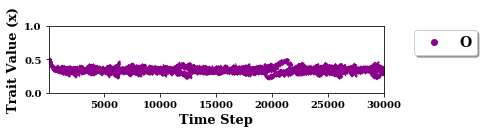

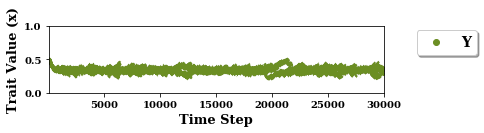

23.523963602852874


In [453]:
run([x,l],30000,10,42,0.5,0.2)

176.21728110313416


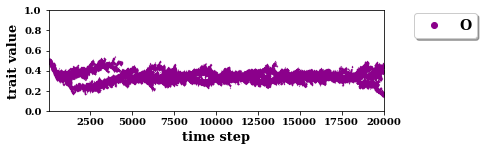

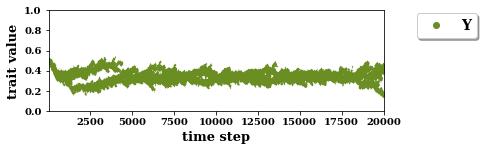

15.391810363188624


In [404]:
run([x,l],20000,10,28,0,0)

170.18919801712036


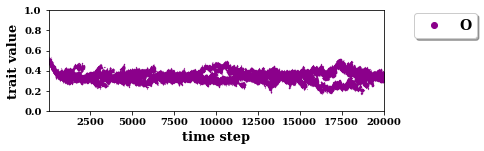

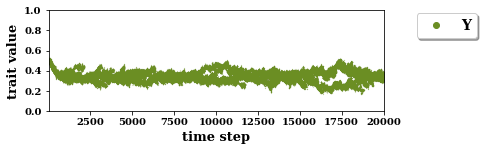

16.124632129735748


In [405]:
run([x,l],20000,10,29,0,0)

In [228]:
print(len(population[population[:,2]==0][:,0][population[population[:,2]==0][:,0] < 0.5]))

0


In [139]:
print(len(population[population[:,2]==1][:,0][population[population[:,2]==1][:,0] > 0.5]))

2


In [140]:
sum(population[:,0][population[:,2]==0])

246.91507135826856

In [141]:
sum(population[:,0][population[:,2]==1])

3.098165598241495

In [2572]:
len(allPopulations[400][allPopulations[400]<0.5])

146

In [674]:
print(sum(population[:,2]))
print(len(population[:,2]))
print(len(population[population[:,2]==0][:,0][population[population[:,2]==0][:,0] < 0.5]))
len(population[population[:,2]==1][:,0][population[population[:,2]==1][:,0] > 0.5])

200.0
450
1


1

In [425]:
old_indices=np.where(population[:,2]==1)
old_indices=np.reshape(old_indices,-1)
np.shape(np.reshape(old_indices,-1))
np.shape(old_indices)[0]

154

### Cost and Benefit Shapes

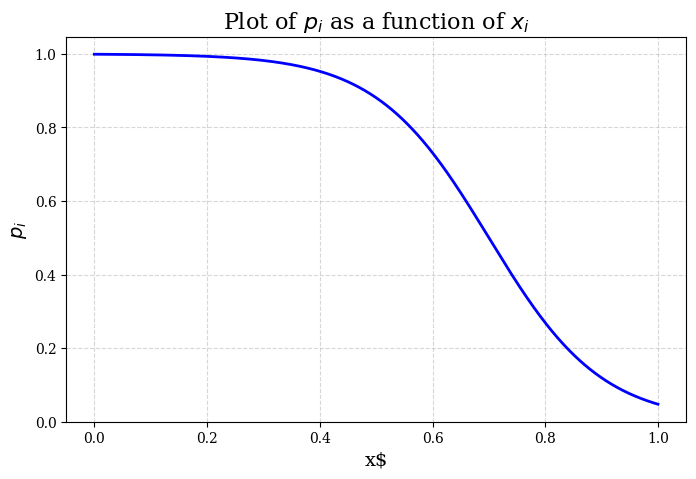

In [136]:
# Parameters from the table
S0 = 0.8  # Example value for S_0 from the table
S1 = 1.0  # Example value for S_1 from the table
gamma = 10  # Given value for gamma from the table

# Define the function p_i
def p_i(x_i):
    exponent = -gamma * ((x_i - 0.5) + (S0 - S1))
    return 1 - 1 / (1 + np.exp(exponent))

# Create an array for x_i from 0 to 1
x_i = np.linspace(0, 1, 1000)

# Calculate p_i for each x_i
p_values = p_i(x_i)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_i, p_values, color='blue', linewidth=2)
plt.xlabel(r"$x_i$", fontsize=14)
plt.ylabel(r"$p_i$", fontsize=14)
plt.title(r"Plot of $p_i$ as a function of $x_i$", fontsize=16)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [1]:
from matplotlib import font_manager



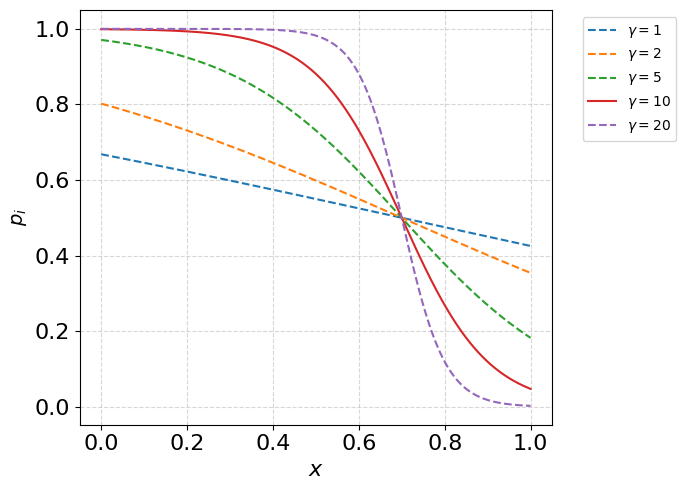

In [4]:


# Define the function p_i
def p_i(x_i, S0, S1, gamma):
    exponent = -gamma * ((x_i - 0.5) + (S0 - S1))
    return 1 - 1 / (1 + np.exp(exponent))

# Create an array for x_i from 0 to 1
x_i = np.linspace(0, 1, 1000)

# Different values for S0, S1, and gamma
S0_values = [0.8]  # Example value for S_0
S1_values = [1.0]  # Example value for S_1
gamma_values = [1, 2, 5, 10, 20]  # Example values for gamma

# Plotting
plt.figure(figsize=(7, 5))
for gamma in gamma_values:
    p_values = p_i(x_i, S0_values[0], S1_values[0], gamma)
    label = f"$\\gamma={gamma}$"
    
    # Use a solid line for gamma = 10 and dashed lines for others
    linestyle = '-' if gamma == 10 else '--'
    
    plt.plot(x_i, p_values, label=label, linestyle=linestyle)

# Customizing the plot
plt.xlabel(r"$x$", fontsize=16, style='italic')  # Italicized x-axis label
plt.ylabel(r"$p_i$", fontsize=14)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the same tick label size for both axes
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


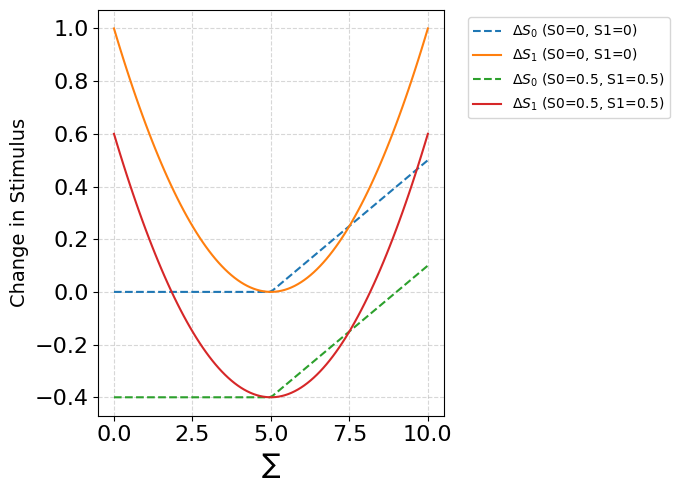

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters from the table
b = 15  # Quadratic coefficient
n = 10  # Group size

B0_min = b * n / 2  # Example minimum benefit
B1_max = 1.0  # Example maximum benefit

lambda_1 = 0.5 / B0_min 
lambda_2 = 0.8
phi_1 = 1
phi_2 = 0.8

# Functions B0 and B1
def B0(x_sum):
    return b * (n - x_sum)  # Using n as the total number of terms

def B1(x_sum):
    return -4 / n**2 * x_sum**2 + 4 / n * x_sum

# Function to calculate Delta S0
def delta_S0(S0, x_sum):
    # print(B0(x_sum))
    return lambda_1 * max(0, B0_min - B0(x_sum)) - lambda_2 * S0

# Function to calculate Delta S1
def delta_S1(S1, x_sum):
    return phi_1 * (B1_max - B1(x_sum)) - phi_2 * S1

# Example x values for the tasks
x_sum_array = np.linspace(0, n, 100)
# print(x_sum_array)
# Different initial values for S0 and S1
S0_values = [0 ,0.5]
S1_values = [0, 0.5]

# Plotting
plt.figure(figsize=(7, 5))

for S0 in S0_values:
    delta_S0_values = [delta_S0(S0, x_sum) for x_sum in x_sum_array]
    delta_S1_values = [delta_S1(S0, x_sum) for x_sum in x_sum_array]
        
    # Plotting each set of values
    plt.plot(x_sum_array, delta_S0_values, label=rf"$\Delta S_0$ (S0={S0}, S1={S0})", linestyle='--')
    plt.plot(x_sum_array, delta_S1_values, label=rf"$\Delta S_1$ (S0={S0}, S1={S0})", linestyle='-')

plt.xlabel(r"$\sum$", fontsize=14)
plt.ylabel("Change in Stimulus", fontsize=14)
# plt.title("Change in S0 and S1 for Different Initial Values", fontsize=16)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.tight_layout()
plt.show()
